This notebook describes the classification part of the PORT-EK pipeline on the "deer" data set from [reference to our paper]. The enriched k-mer count matrix, along with host spieces labels, are used to preict the most likely host of a viral genomic sequence. 
To use this notebook you will need the count matrix saved as output/deer/15mer_counts_for_classifier.csv generated by running notebooks/deer_analysis.ipynb notebook. For evaluating the model on out of the bag (OoB) set, you will need the appropriate k-mer indices generated by running the following commands from the main PORT-EK directory
 - python PORTEKfind.py "input/deer/EPI_SET_240422oy.fasta" "output/deer/15mer_oob_indices/" --k 15 --group deer
 - python PORTEKfind.py "input/deer/EPI_SET_240422xu.fasta" "output/deer/15mer_oob_indices/" --k 15 --group human

In [1]:
import sys
import pathlib
import json
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, multilabel_confusion_matrix, confusion_matrix, f1_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True

2024-05-22 11:21:41.590312: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 11:21:41.614567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 11:21:42.012866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1. Define data set specific values

In [2]:
PLOT_CMAP = {
    "deer": ("#ffa401", 1),
    "deer over-represented": ("#ffa401", 1),
    "human": ("#005ff5", 1), 
    "human over-represented": ("#005ff5", 1)
}

2. Import counts, separate features and labels

In [3]:
counts = pd.read_csv("../output/deer/15mer_counts_for_classifier.csv", index_col=0)
kmer_group = counts.loc['group'].drop('host')
counts.drop('group', inplace=True)
X = counts.drop('host',axis=1).astype(float)
y = counts['host'].astype(float)


/tmp/ipykernel_191661/3073336838.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

3. Calculate k-mer count correlation and select only linearily independant k-mers. This may take a long time, depending on the number of initial k-mers.

In [4]:
#Calculate k-mer count correlation matrix
X_corr = X.corr()
print("Done calculating k-mer count corrrelation.")

#Construct a graph where nodes represent k-mers and edges connect k-mers with count correlation coefficient of more than 0.9 
features_list = list(X_corr.columns)
edge_list = set()
for i in range(1,len(features_list)):
    print(i, end='\r',flush=True)
    k1 = features_list[i]
    for j in range(i):
        k2 = features_list[j]
        if abs(X_corr.loc[k1,k2] > 0.9):
            edge = (k1,k2)
            edge_list.add(edge)
corr_graph = nx.Graph(edge_list)
del edge_list
print("Done constructing correlation graph.")

#Calculate count correlation with host label for each k-mer
y_corr_dict={}
y_corr_abs_dict={}
for kmer in corr_graph.nodes:
    y_corr = X[kmer].corr(y)
    y_corr_abs = abs(y_corr)
    y_corr_dict[kmer] = y_corr
    y_corr_abs_dict[kmer] = y_corr_abs
nx.set_node_attributes(corr_graph, y_corr_dict,"y_corr")
nx.set_node_attributes(corr_graph, y_corr_abs_dict,"y_corr_abs")

#Seperate correlated k-mer groups
corr_groups = [corr_graph.subgraph(c).copy() for c in nx.connected_components(corr_graph)]

#List k-mer missing from the graph, i.e. not correlated with any other k-mer
indep_kmers = [kmer for kmer in features_list if kmer not in corr_graph.nodes]
print(f"There are {len(corr_groups)} groups of k-mers with highly correlated counts.")
#For large k-mers sets, you may want to delete the graph to save memory. Uncomment the following line.
# del corr_graph

#From each group of correlated k-mers select the one with the highest correlation of counts with host labels and add to the list of independent k-mers.
for group in corr_groups:
    y_corr_abs = nx.get_node_attributes(group,"y_corr_abs")
    indep_kmers.append(max(y_corr_abs, key=lambda x: y_corr_abs[x]))
del corr_groups

#Extract the count matrix of independent k-mers from the count matrix of all enriched k-mers
X_indep = X.loc[:,indep_kmers]
print(f"{len(X_indep.columns)} linearily independent k-mers selected.")

Done calculating k-mer count corrrelation.
Done constructing correlation graph.
There are 178 groups of k-mers with highly correlated counts.
211 linearily independent k-mers selected.


In [5]:
#Uncomment the following lines as needed to save/load the independent k-mers count matrix and avoid re-calculation of correlation.

X_indep.to_csv("../output/deer/15mer_indep_counts.csv") 
# X_indep = pd.read_csv("../output/deer/15mer_indep_counts.csv", index_col=0)

Optional: plot k-mer counts correlation clustermap and graph. WARNING: make take a long time and a lot of memory, especially for large k-mer sets!

/home/labadmin/repos/PORT-EK/env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/labadmin/repos/PORT-EK/env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


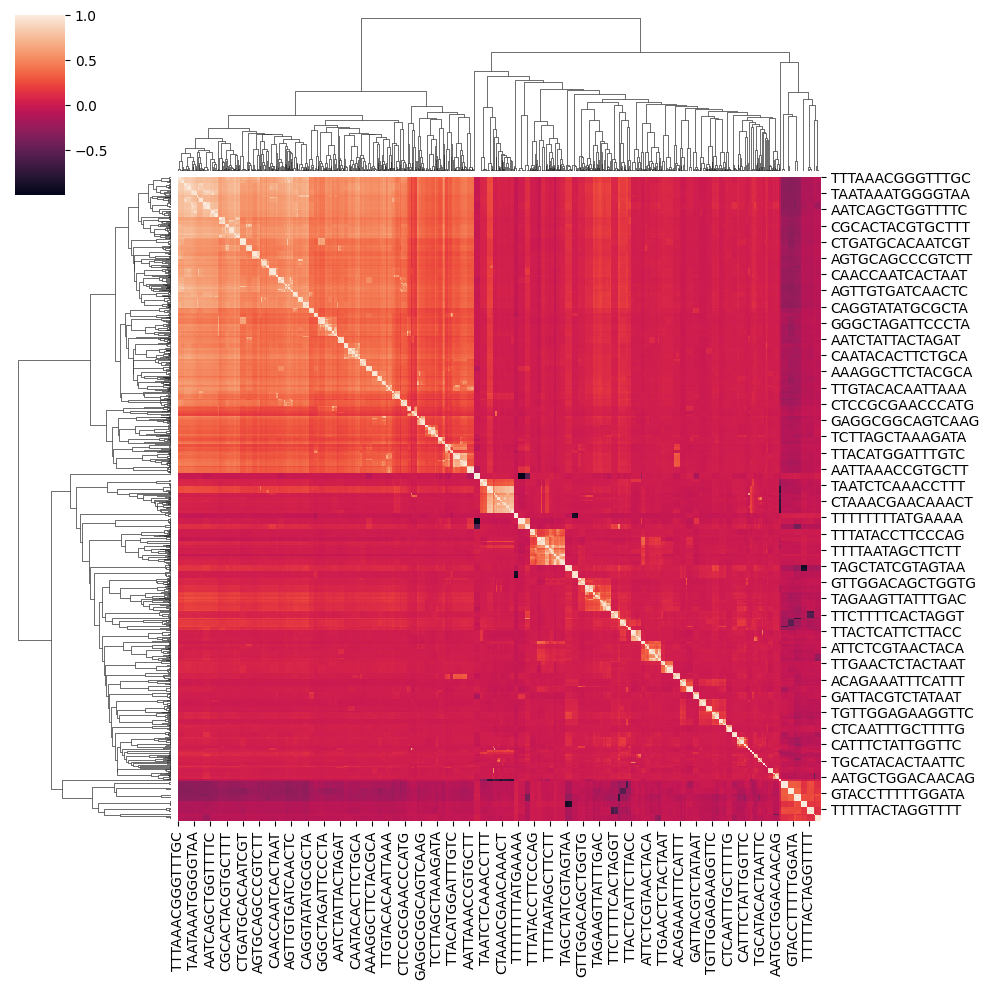

In [6]:
sns.clustermap(X_corr)

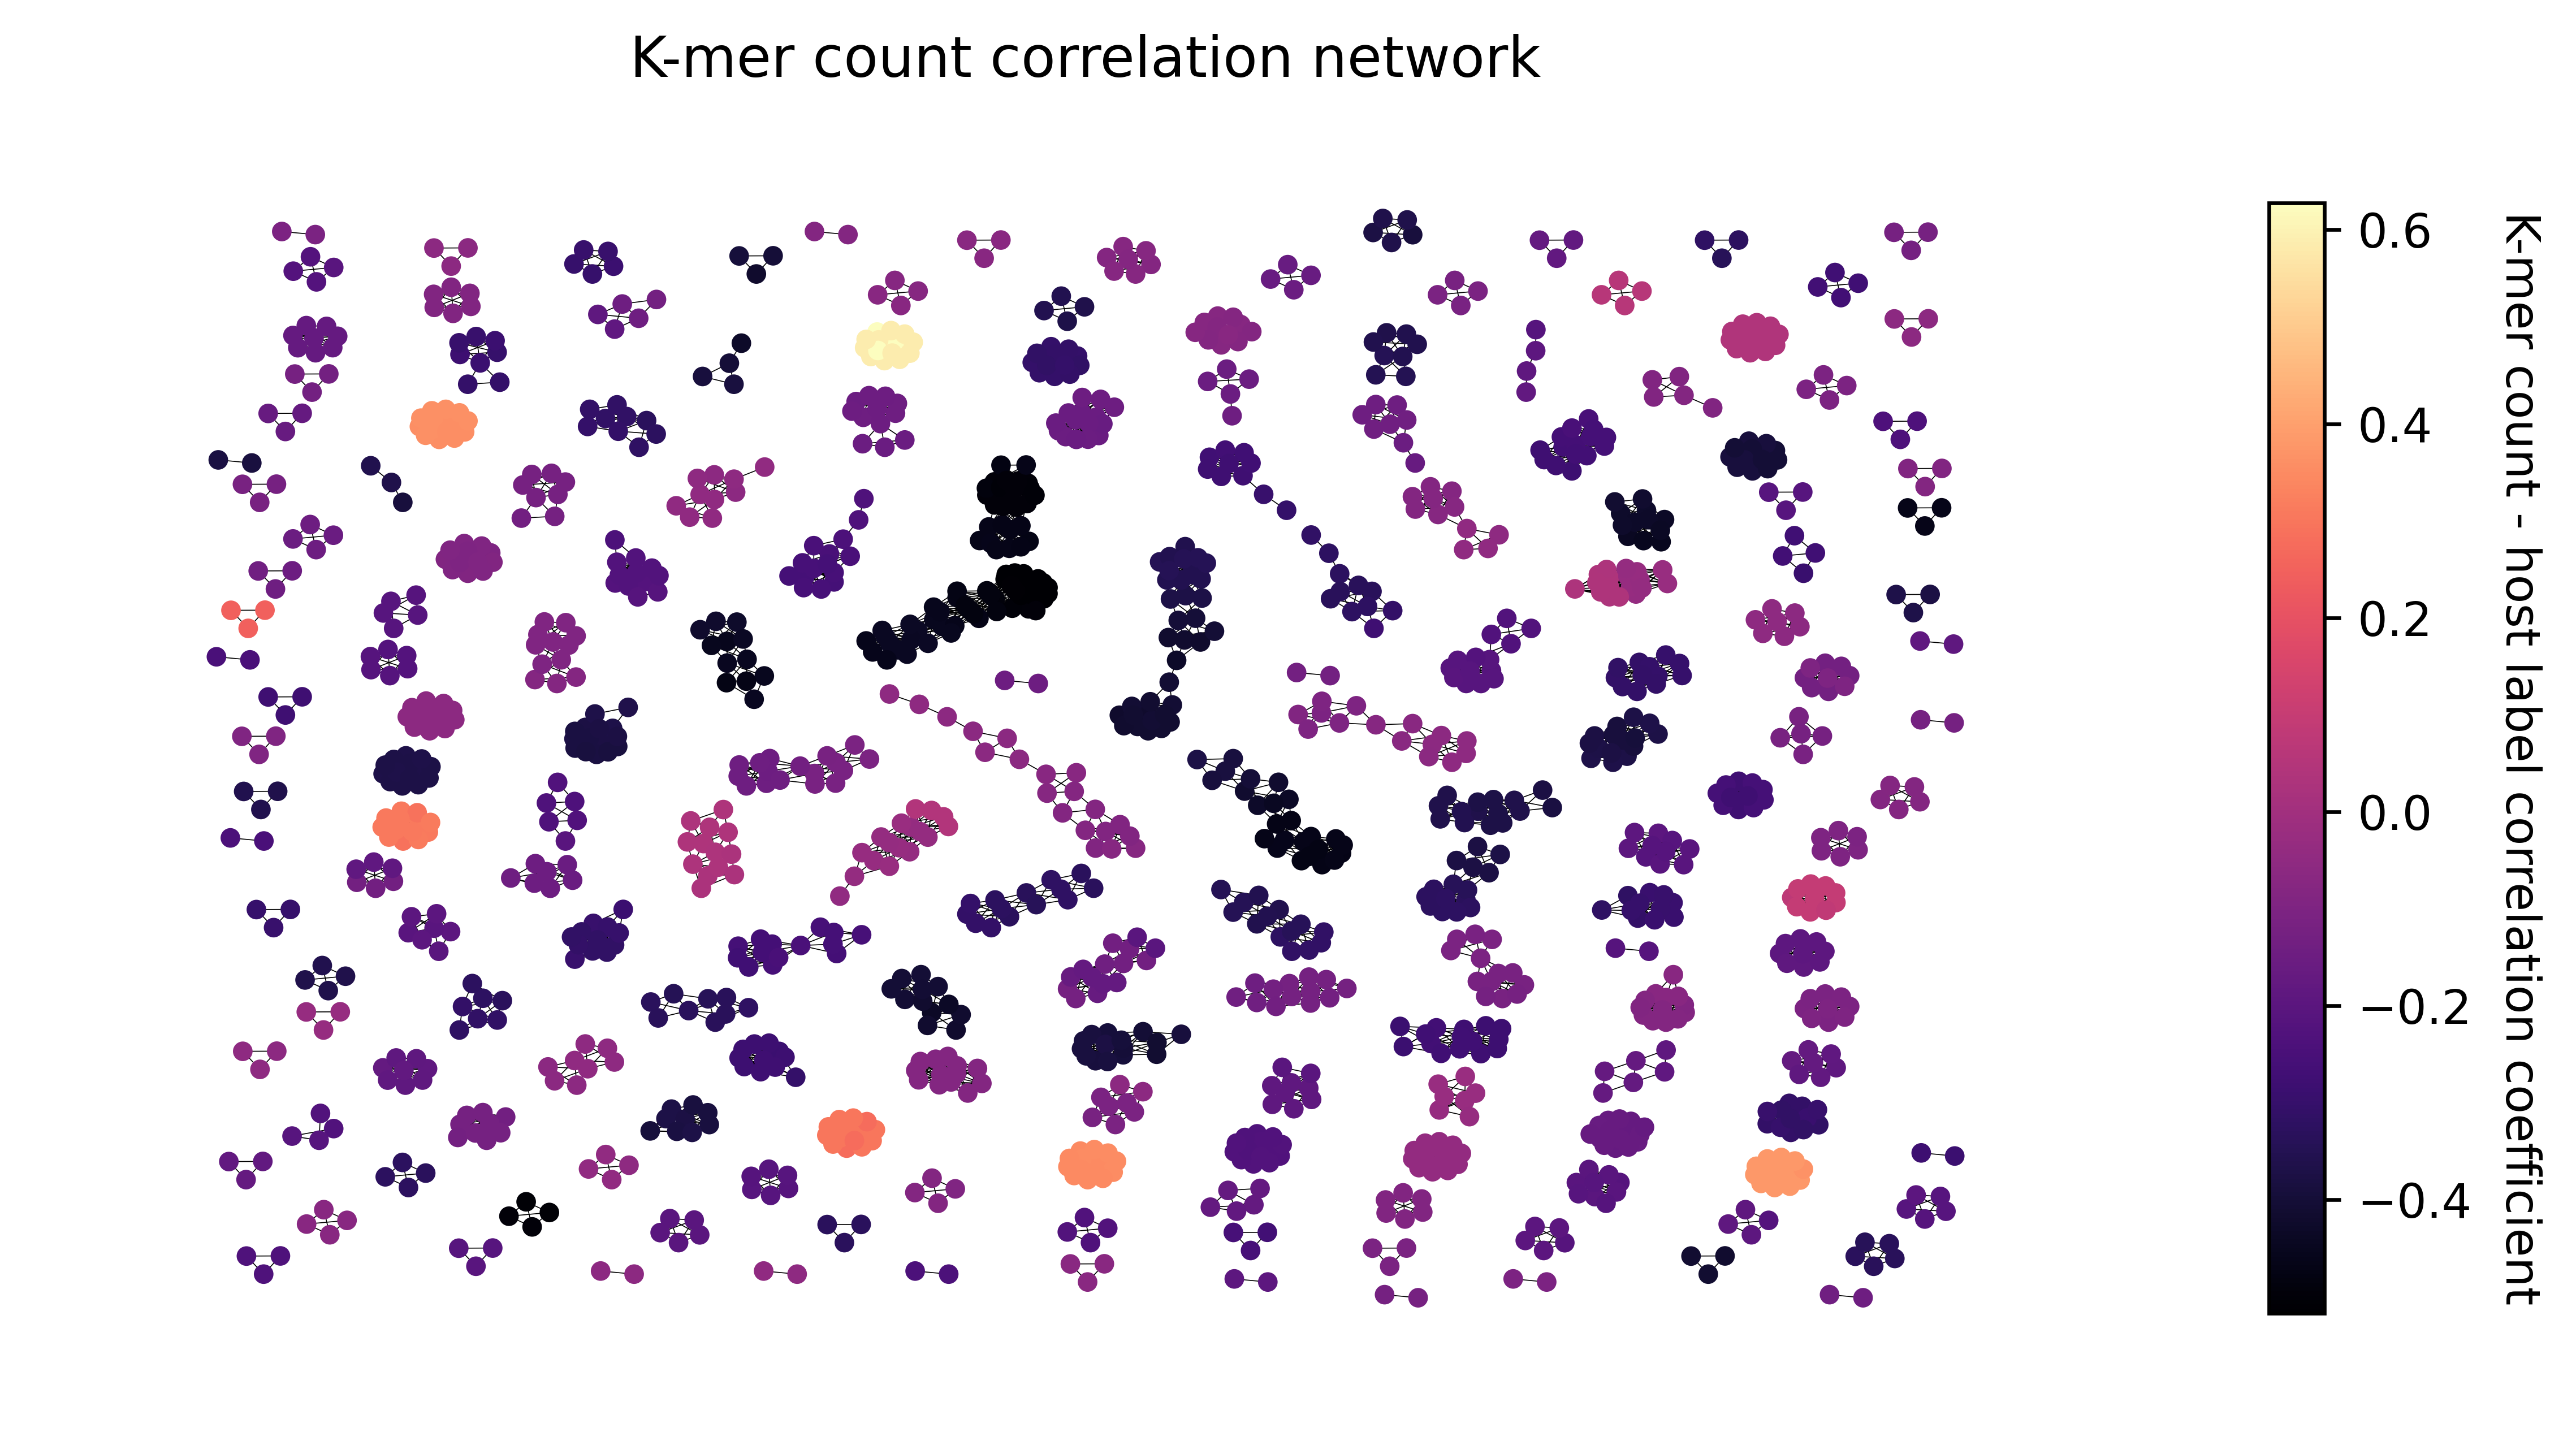

In [7]:
fig, ax = plt.subplots()
corr_pos = nx.nx_agraph.graphviz_layout(corr_graph, prog="neato")
colors = [corr_graph.nodes[node]["y_corr"] for node in list(corr_graph.nodes())]
nx.draw(corr_graph, pos=corr_pos, node_size=10, node_color=colors, cmap='magma', with_labels=False, width=0.2)
fig.set_size_inches(10,5)
fig.set_dpi(600)
ax.set_title("K-mer count correlation network")
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="magma", norm=plt.Normalize(min(colors),max(colors))), ax=ax, shrink = 0.85)
cbar.set_label("K-mer count - host label correlation coefficient", rotation=270, labelpad=15)
plt.show()

4. Calculate k-mer importances acording to MDI and premutation importance, using a random forest classifier.

In [8]:
#Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_indep,y, test_size=0.3, stratify=y, random_state=14)

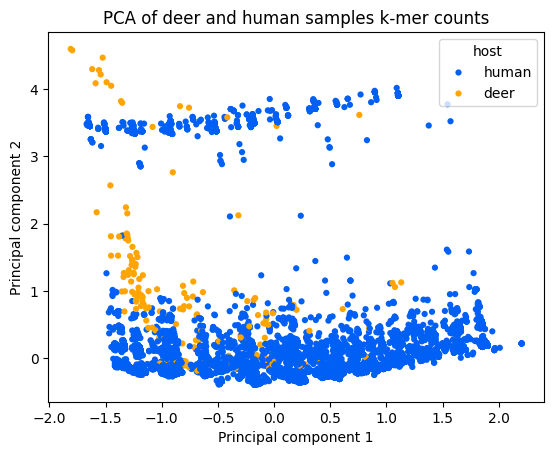

<Figure size 640x480 with 0 Axes>

In [9]:
#Perform and plot PCA 
y_names = y_train.map(lambda y: "deer" if y == 1.0 else "human")

pca = PCA(2)
X_pca = pca.fit_transform(X_train)

fig, ax = plt.subplots()
ax.set_title('PCA of deer and human samples k-mer counts')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_names, palette=PLOT_CMAP,s=20, linewidth = 0)
plt.show()

#Uncomment the following line to save the plot as svg.
plt.savefig("../output/deer/PCA.svg", dpi = 600, format = "svg", bbox_inches='tight')

In [10]:
#perform classification using a simple random forest
rf_imp= RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=14)
rf_imp.fit(X_train,y_train)
y_pred = rf_imp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10030
         1.0       0.94      0.76      0.84       101

    accuracy                           1.00     10131
   macro avg       0.97      0.88      0.92     10131
weighted avg       1.00      1.00      1.00     10131



In [11]:
imps = pd.DataFrame({'name':rf_imp.feature_names_in_,'importance':rf_imp.feature_importances_}).set_index('name')
perm_imps= permutation_importance(rf_imp, X_test, y_test, scoring='f1', random_state=14)
perm_importances = pd.DataFrame(perm_imps['importances_mean'], index=X_test.columns, columns=['perm_importance'])
com_imp = pd.concat([imps, perm_importances], axis=1).sort_values('importance', ascending=False)

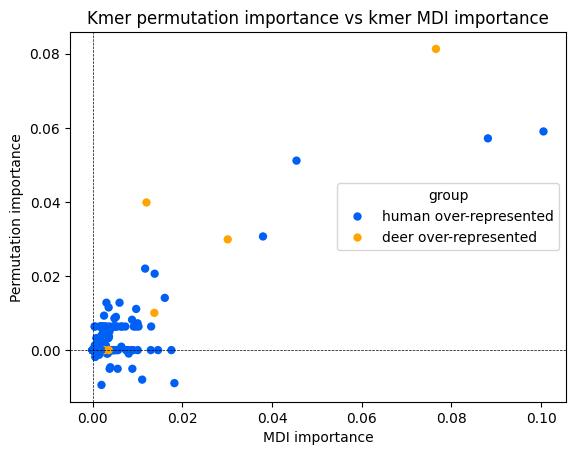

In [12]:
#Plot permutation and MDI importance
fig,ax=plt.subplots()
sns.scatterplot(data = com_imp, x='importance', y='perm_importance', hue=kmer_group, palette=PLOT_CMAP, linewidth = 0)
ax.axhline(0, linestyle='dashed', linewidth=0.5,color='black')
ax.axvline(0, linestyle='dashed', linewidth=0.5,color='black')
ax.set_title('Kmer permutation importance vs kmer MDI importance')
ax.set_xlabel('MDI importance')
ax.set_ylabel('Permutation importance')
plt.show()
#Uncomment the following line to save the plot as svg.
#plt.savefig("../output/deer/kmer_feature_importance.svg", dpi = 600, format = "svg")

In [13]:
#Discard unimportant k-mers and redo train/test split.
imp_kmers = com_imp[(com_imp['importance'] >= 0) & (com_imp['perm_importance']>=0)].index
print(f"{len(imp_kmers)} k-mers selected after importance filter.")
X_imp = X_indep.loc[:,imp_kmers]
X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp,y, test_size=0.3, stratify=y, random_state=14)

199 k-mers selected after importance filter.


5. Classify the samples according to most probable host using various model architectures.

In [14]:
#Calculate class weights
pos_weigth = len(y_train)/len(y_train[y_train == 1])
neg_weigth = len(y_train)/len(y_train[y_train == 0])
print(neg_weigth, pos_weigth)

#Set up and build neural-network
keras.utils.set_random_seed(14)
N_KMERS = len(X_imp.columns)
HIDDEN_DIMS = [1024,256]
DROPOUT = 0.3
CLASS_WIEGHTS = {0.0:1.0,1.0:100.5}
LEARNING_RATE = 1e-5
N_EPOCHS = 50
BATCH_SIZE = 8

metrics = ['accuracy', keras.metrics.AUC()]
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=3)
classification_optimizer = keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

def build_nn(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(input_shape,)))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(units=HIDDEN_DIMS[0],activation='gelu', kernel_constraint=keras.constraints.MaxNorm(3)))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(units=HIDDEN_DIMS[1],activation='gelu', kernel_constraint=keras.constraints.MaxNorm(3)))
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(units=1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = classification_optimizer, metrics=['accuracy'])
    return model

model_nn = build_nn(N_KMERS)

1.010042305884364 100.57872340425531


2024-05-22 11:24:00.438472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-22 11:24:00.457150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-22 11:24:00.457250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

I0000 00:00:1716369841.243933  192687 service.cc:145] XLA service 0x741c7c003aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716369841.243950  192687 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-05-22 11:24:01.258261: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-22 11:24:01.325400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716369842.663258  192687 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10030
         1.0       0.94      0.76      0.84       101

    accuracy                           1.00     10131
   macro avg       0.97      0.88      0.92     10131
weighted avg       1.00      1.00      1.00     10131



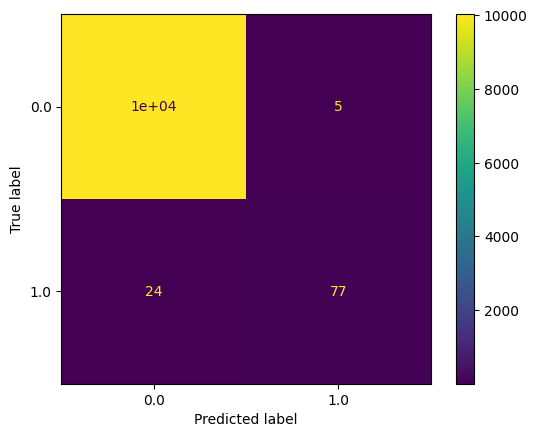

In [15]:
#Train and test neural network
model_nn.fit(X_imp_train,y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, class_weight=CLASS_WIEGHTS, validation_split=0.1, callbacks=[early_stopping], verbose=0)

y_score = model_nn.predict(X_imp_test)
y_pred = y_score > 0.5
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10030
         1.0       0.97      0.75      0.85       101

    accuracy                           1.00     10131
   macro avg       0.99      0.88      0.92     10131
weighted avg       1.00      1.00      1.00     10131



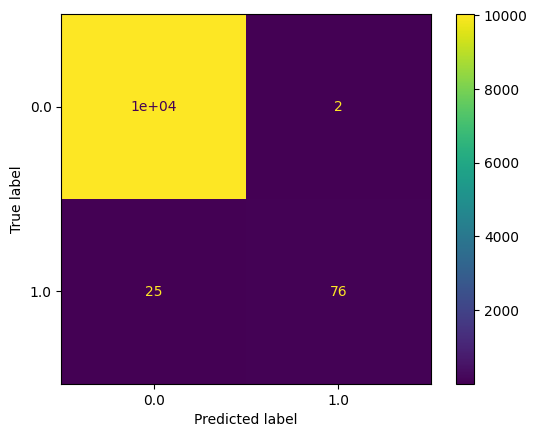

In [16]:
#Train and test random forest
model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=14)
model_rf.fit(X_imp_train, y_train)
y_score = model_rf.predict(X_imp_test)
print(classification_report(y_test, y_score))
ConfusionMatrixDisplay.from_predictions(y_test,y_score)

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     10030
         1.0       0.34      0.87      0.49       101

    accuracy                           0.98     10131
   macro avg       0.67      0.93      0.74     10131
weighted avg       0.99      0.98      0.99     10131



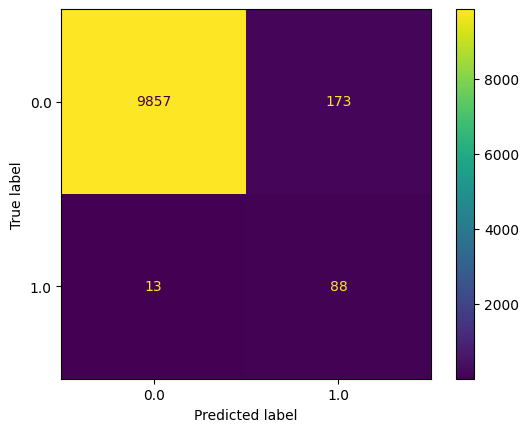

In [17]:
#Train and test ridge regression classifier
model_rc = RidgeClassifier(alpha=1,class_weight='balanced',random_state=14)
model_rc.fit(X_imp_train, y_train)
y_score = model_rc.predict(X_imp_test)
print(classification_report(y_test, y_score))
ConfusionMatrixDisplay.from_predictions(y_test,y_score)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10030
         1.0       0.84      0.89      0.87       101

    accuracy                           1.00     10131
   macro avg       0.92      0.94      0.93     10131
weighted avg       1.00      1.00      1.00     10131



/home/labadmin/repos/PORT-EK/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


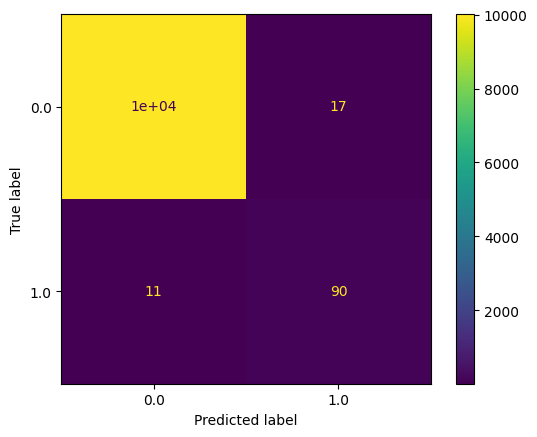

In [18]:
#Train and test linear support vector machine classifier
model_lsvc = LinearSVC(class_weight='balanced',random_state=14)
model_lsvc.fit(X_imp_train, y_train)
y_score = model_lsvc.predict(X_imp_test)
print(classification_report(y_test, y_score))
ConfusionMatrixDisplay.from_predictions(y_test,y_score)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10030
         1.0       0.99      0.83      0.90       101

    accuracy                           1.00     10131
   macro avg       0.99      0.92      0.95     10131
weighted avg       1.00      1.00      1.00     10131



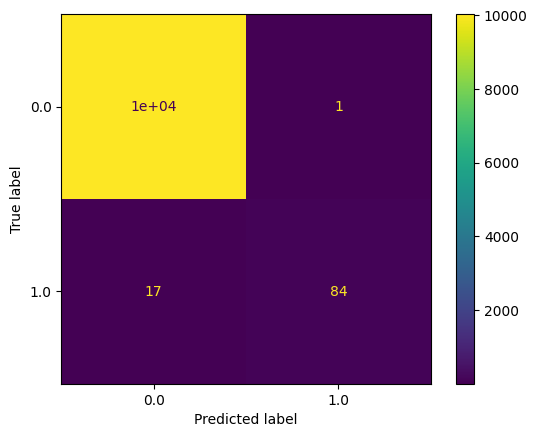

In [19]:
#Train and test gradient boosting classifier
model_gb = GradientBoostingClassifier(n_estimators=100,random_state=14)
model_gb.fit(X_imp_train, y_train)
y_score = model_gb.predict(X_imp_test)
print(classification_report(y_test, y_score))
ConfusionMatrixDisplay.from_predictions(y_test,y_score)

6. Test the models on the deer OoB data set

In [20]:
#Define data set specific values.
OOB_INPUT_PATH = '../output/deer/15mer_oob_indices'


def assign_host(sample_id):
    if "deer" in sample_id:
        host = 1.0
    else:
        host = 0.0
    return host

#Read OoB sample names and k-mer sequences.
oob_kmer_set = set()
oob_sample_list = []
in_path = pathlib.Path(OOB_INPUT_PATH).glob('**/*')
for filename in in_path:
    oob_sample_list.append(filename.stem)
    with open(filename, mode="r") as in_file:
        temp_dict = json.load(in_file)
    oob_kmer_set.update(temp_dict.keys())

#Prepare OoB count matrix.
oob_counts = pd.DataFrame(0, index=list(oob_kmer_set), columns=oob_sample_list, dtype="uint8")
in_path = pathlib.Path(OOB_INPUT_PATH).glob('**/*')
for filename in in_path:
    with open(filename, mode="r") as in_file:
        temp_dict = json.load(in_file)
    count_dict = {f"{filename.stem}":[len(pos) for pos in temp_dict.values()]}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    oob_counts.update(temp_df)
oob_counts = oob_counts.T

#Select the only the k-mers used by the models.
X_oob = pd.DataFrame(0, index = oob_counts.index, columns=X_imp.columns)
X_oob.update(oob_counts)

#Assing numerical host labels.
y_oob = X_oob.index.map(assign_host)

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6705
         1.0       0.91      0.59      0.71        70

    accuracy                           1.00      6775
   macro avg       0.95      0.79      0.86      6775
weighted avg       0.99      1.00      0.99      6775



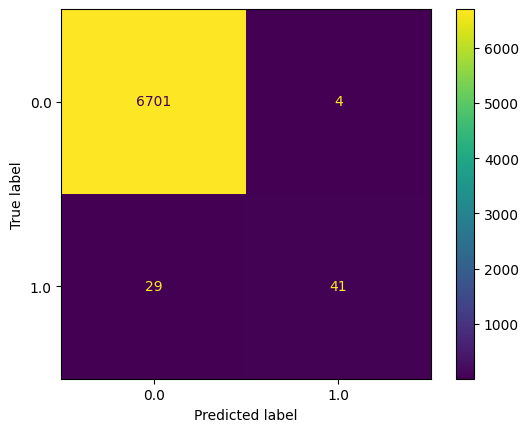

In [21]:
#Test neural network on OoB data.
y_oob_score = model_nn.predict(X_oob)
y_oob_pred = y_oob_score > 0.5
print(classification_report(y_oob, y_oob_pred))
ConfusionMatrixDisplay.from_predictions(y_oob,y_oob_pred)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      6705
         1.0       0.88      0.41      0.56        70

    accuracy                           0.99      6775
   macro avg       0.94      0.71      0.78      6775
weighted avg       0.99      0.99      0.99      6775



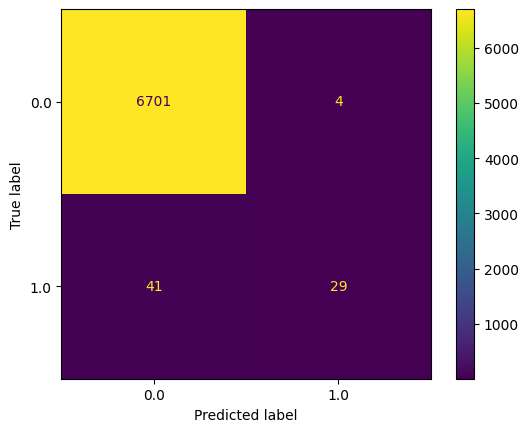

In [22]:
#Test random forest on OoB data.
y_oob_pred = model_rf.predict(X_oob)
print(classification_report(y_oob, y_oob_pred))
ConfusionMatrixDisplay.from_predictions(y_oob,y_oob_pred)

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      6705
         1.0       0.16      0.69      0.26        70

    accuracy                           0.96      6775
   macro avg       0.58      0.82      0.62      6775
weighted avg       0.99      0.96      0.97      6775



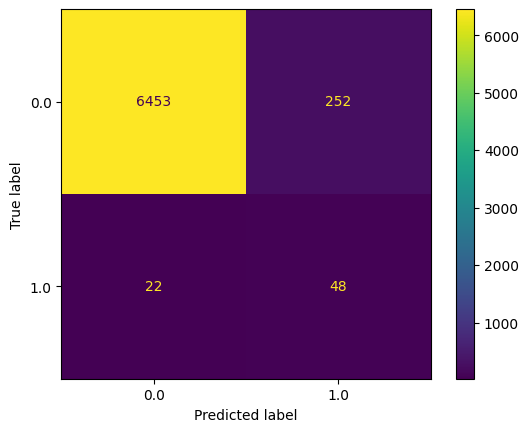

In [23]:
#Test ridge regression classifier on OoB data.
y_oob_pred = model_rc.predict(X_oob)
print(classification_report(y_oob, y_oob_pred))
ConfusionMatrixDisplay.from_predictions(y_oob,y_oob_pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6705
         1.0       0.59      0.61      0.60        70

    accuracy                           0.99      6775
   macro avg       0.79      0.80      0.80      6775
weighted avg       0.99      0.99      0.99      6775



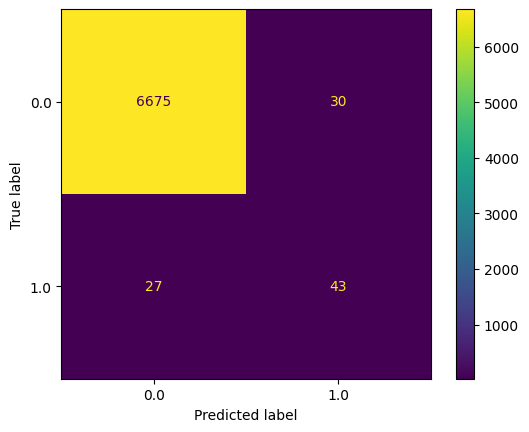

In [24]:
#Test linear support vector machine classifier on OoB data.
y_oob_pred = model_lsvc.predict(X_oob)
print(classification_report(y_oob, y_oob_pred))
ConfusionMatrixDisplay.from_predictions(y_oob,y_oob_pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6705
         1.0       0.74      0.53      0.62        70

    accuracy                           0.99      6775
   macro avg       0.87      0.76      0.81      6775
weighted avg       0.99      0.99      0.99      6775



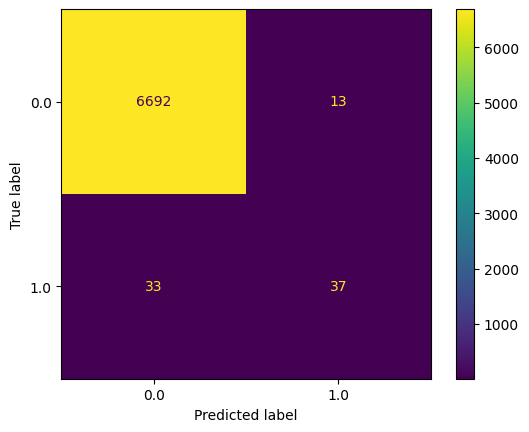

In [25]:
#Test gradient boosting on OoB data.
y_oob_pred = model_gb.predict(X_oob)
print(classification_report(y_oob, y_oob_pred))
ConfusionMatrixDisplay.from_predictions(y_oob,y_oob_pred)

7. Bootstrapping

In [26]:
# Train the neural network on 100 diffrent train/test splits and evaluate (also on OoB data). 
#This helps check if the performance is not an artifact of thje previous train/test split.

f1s = []
f1s_oob = []
for i in range(100):
    X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp,y, test_size=0.3, stratify=y, random_state=i)
    classification_optimizer = keras.optimizers.AdamW(learning_rate=LEARNING_RATE)
    model_nn_bs = build_nn(N_KMERS)
    model_nn_bs.fit(X_imp_train,y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, class_weight=CLASS_WIEGHTS, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_score = model_nn_bs.predict(X_imp_test, verbose=0)
    y_score_oob = model_nn_bs.predict(X_oob, verbose=0)
    y_pred = y_score > 0.5
    y_pred_oob = y_score_oob > 0.5
    f1s.append(f1_score(y_test, y_pred))
    f1s_oob.append(f1_score(y_oob, y_pred_oob))
    print(i, end="\r")

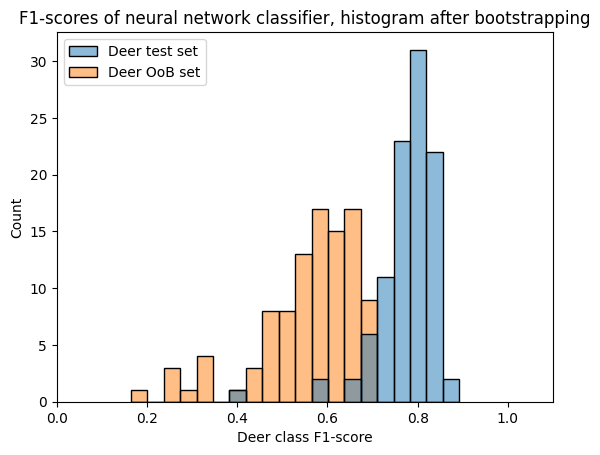

In [27]:
#Plot histograms of f1-scores
fig, ax = plt.subplots()
f1s_df = pd.DataFrame({"Deer test set": f1s, "Deer OoB set": f1s_oob})
sns.histplot(f1s_df, bins=20)
ax.set_title("F1-scores of neural network classifier, histogram after bootstrapping")
ax.set_xlim(0,1.1)
ax.set_xlabel("Deer class F1-score")
plt.show()

#Uncomment the following line to save the plot as svg.
fig.savefig("../output/deer/deer_nn_bootstrap.svg", dpi=600, format="svg")